# 数据标准化与随机梯度下降

### 数据标准化
$$ {x}_{j}^{'}=\frac{{x}_{j}-{\mu}_{j}}{{\sigma}_{j}} $$

In [1]:
from sklearn.datasets import load_iris
import numpy as np

# 样本0-49类标为0，50-99类标为1，100-149类标为2
# 所以只选前100个样本，并将类标转换为1和-1
# 为了可视化方便，只选两个特征
X, y = load_iris(return_X_y=True)
X = X[:100, :2]
y = y[:100]
y = np.where(y == 0, 1, -1)

# 标准化
X_std = np.copy(X)
for col in range(X.shape[1]):
    X_std[:, col] = (X[:, col] - X[:, col].mean()) / X[:, 0].std()

### 随机梯度下降

每次使用一个训练样本渐进地更新权重
$$ \Delta{w}=\eta({y}^{(i)}-\phi({z}^{(i)})){x}^{(i)} $$

使用随着时间变化的自适应学习速率代替固定学习速率（没在代码中实现）
$$ \eta=\frac{{c}_{1}}{迭代次数+{c}_{2}} $$

In [2]:
from matplotlib import pyplot as plt

class AdalineSGD:
    """自适应线性神经网络(随机梯度下降)

    :param
        eta: float 学习步长，在0到1之间
        iter: int 迭代次数

    :arg
        w: array 权重向量，由目标函数的各特征系数组成，含一个常数项，所以长度为 特征数+1
        errors: list 每次迭代，预测值与实际值不符的样本个数
        shuffle: bool 是否打乱数据顺序
        random_state: int 设置一个随机种子，保证多次训练的一致性
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        # 学习步长
        self.eta = eta
        # 迭代次数
        self.n_iter = n_iter
        # 其他选项
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """fit训练

        :param
            X: n*m-matrix 样本矩阵，行n为样本数，列m为特征数
            y: array 分类向量， 由分类标签（即-1或1)组成，长度为样本数

        :return
            self: object
        """
        # 创建一个空列表用以记录每次J(w)
        self.costs = list()

        # 创建一个维数比特征数多一的零向量，最后一项为常数项
        self.initialize_weights(X.shape[1])

        # 迭代n_iter次
        for each_time in range(self.n_iter):
            # 打乱样本顺序
            if self.shuffle:
                X, y = self.shuffle_it(X, y)

            # 批量梯度下降更新权重
            cost = list()
            for x_i, y_i in zip(X, y):
                cost.append(self.update_weights(x_i, y_i))
            avg_cost = np.mean(cost)
            self.costs.append(avg_cost)

        return self
    
    def partail_fit(self, X, y):
        # 如果是第一次训练，就初始化权重
        if not self.w_initialized:
            self.initialize_weights(X.shape[1])
            
        # 渐进更新权重
        for x_i, y_i in zip(X, y):
            self.update_weights(x_i, y_i)

    def net_input(self, X):
        """净输入函数

        :param
            X: matrix 样本矩阵，一行为一条样本，每列代表一个特征

        :return:
            z: array 每条样本x与w的线性组合值组成的向量
        """
        z = np.dot(X, self.w[:-1]) + self.w[-1]
        return z

    def activation(self, X):
        """激励函数

        :param
            X: matrix 样本矩阵，一行为一条样本，每列代表一个特征

        :return:
            z: array 每条样本x与w的线性组合值组成的向量
        """
        # 简单的恒等函数
        z = self.net_input(X)
        return z

    def predict(self, X):
        """量化器

        :param
            X: matrix 样本矩阵，一行为一条样本，每列代表一个特征

        :return:
            y_predict: int 分类预测值 1或-1
        """
        theta = 0.0
        y_predict = np.where(self.activation(X) >= theta, 1, -1)
        return y_predict

    def err_plot(self):
        plt.plot(range(len(self.costs)), self.costs)
        plt.xlabel('n_iter')
        plt.ylabel('number of errors')
        plt.show()

    def initialize_weights(self, m):
        self.w = np.zeros(m + 1)
        self.w_initialized = True
        return self

    def shuffle_it(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def update_weights(self, x_i, y_i):
        """更新权重

        :param
            x_i: array 一条样本
            y_i: int 分类类标

        :return:
            cost: float 代价函数值
        """
        output = self.net_input(x_i)
        error = y_i - output
        self.w[:-1] += self.eta * np.dot(x_i, error)
        self.w[-1] += self.eta * error
        cost = 0.5 * np.square(error)
        return cost

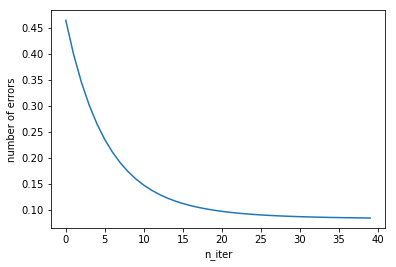

In [3]:
ada = AdalineSGD(eta=0.001, n_iter=40)
ada.fit(X_std, y)
ada.err_plot()

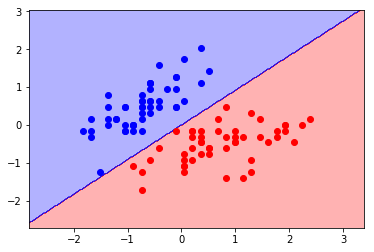

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y ,classifier, resolution=0.02):
    # np.unique(y) 表示y种类数
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 横轴、纵轴范围
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    # 把x1_min,x1_max,x2_min,x2_max围合的矩形类所用点用感知器分类， 并根据分类用contourf填色
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    # 遍历每个类别
    for idx, cl in enumerate(np.unique(y)):
        # 当前类别中，横坐标为特征0， 纵坐标为特征1, 根据类别控制点的颜色
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], c=cmap(cl), label=cl)
    
    plt.show()

plot_decision_regions(X_std, y, classifier=ada)